In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from importlib import reload
from agents import Agent
from tasks import akam_tasks as ts
import config as co
from utils import *  # get_current_file_name, goto_root_dir
import pprint
import joblib
from path_settings import *
import CustomMapper.CustomMapper as c
import torch
import pickle
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import torch.nn as nn
import time
from agents.DynamicSystems import ISNNet
from agents.ComplexAgent import DynamicAgent
import copy
import plotly.express as px

from CustomMapper.CustomMapper import CustomDataset

reload(ts)
pp = pprint.PrettyPrinter(indent=4, depth = 4)
goto_root_dir.run()

2025-09-11 23:25:22.019741: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-11 23:25:22.103142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-11 23:25:22.143835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-11 23:25:22.144095: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-11 23:25:22.206168: I tensorflow/core/platform/cpu_feature_gua

In [2]:
agent = "MB0s"
try: 
    experiment = pickle.load(open(DATA_PATH/f"experiment_{agent}_1.pkl", "rb"))
    experiment.initialise_dataloaders()
    experiment.configs["model_specs"]["model_params"]["batch_size"] = 64
    experiment.initialise_trainer(experiment.configs)
except FileNotFoundError:
    print(f"Experiment for {agent} not found. Please run the simulation first.")
    tasks = {
        # "PRL": ts.Two_step(com_prob=1),  # common transition always happens
        # "RTS": ts.Two_step(),
        # "NTS": ts.Two_step(rew_gen="trans_rev"),
        "walk": ts.Two_step(rew_gen="walks"),
    }
    N_blocks = 1000
    N_trials = 100
    device = "cpu"
    exp_folder = 0  #automatically generate this
    seed = 0
    # For now only consider RTS
    agents = {}
    config = {}
    cog_types = ["MB0s", "LS0", "MB0", "MB1"]

    for cog_type in cog_types:
        cog_config = co.sim_config_from_inputs(False, 
                                            agent_type="RTSCog", 
                                            cog_type=cog_type, 
                                            device=device, 
                                            seed=seed,
                                            num_blocks=N_blocks,
                                            num_trials=N_trials,
                                            exp_folder=0)
        config[f'walks_{cog_type}'] = cog_config
        agents[f'walks_{cog_type}'] = Agent(cog_config['agent_type'], config = cog_config)

    for cog_type in cog_types: 
        agents[f'walks_{cog_type}'].simulate(tasks["walk"], config[f'walks_{cog_type}'], save = True)
        
    # Trainer parameters
    batch_size = 20
    RTRNN_config = {
        "task": "PRL_Bartolo", 
        "dt": 0.02, # 0.02s time step, as in Jaffe et al. 
        "T": 200, # 1s upper for RT
        "n_blocks": 800,
        "cog_data": SIM_SAVE_PATH / 'simulated_Akam_RTS' / 'LS0_seed0.pkl',
        "bias": 0.01, 
        "ndt_s": 0.01, 
        "ndt_mu": 0.1, 
        "driftscale": 2, 
        "redo_choices": False,
        "trainer_type": "RTRNNTrainer",
        "model_specs": {
            "model_name": "RTRNN", 
            "model_path": "Network_models.RTRNN",
            "model_params":{
                "batch_size": batch_size, "input_size": 6, "output_size": 2, "hidden_size": 16, "recurrence_per_trial": 2,
                "cell_type":"GRU", "trial_output_hidden": 0, "trial_output_hidden_size": [], # if want hidden output layers (deep output, then give a list)
                "trial_output_hidden_nonlinearities": [], "pad_zeros":0, "last_step": False
            },
        },
        "rt_weight": 0.01,
        "device": "cuda", 
        "scheduler": {
            "name": "ReduceLROnPlateau",
            "params": {
                "mode": "min",
                "factor": 0.1,
                "patience": 100,
                "min_lr": 5e-4,
                "cooldown": 50, 
            },
        }, 
        "optimizer_specs":{
            "optimizer_name": "Adam",
            "optimizer_params": {
                "lr": 0.0005,
            },
        },
        "training_config":{
            "task_id": "1.1",
            "task_config": {
                "task": "PRL_Bartolo",
            }
        },  
        "save_path": MODEL_SAVE_PATH ,
        "check_path": MODEL_SAVE_PATH,
        "log_path": LOG_PATH, # These are to be modified when the big configs gets defined
    }

    for agent in ["MB0s", "LS0", "MB0", "MB1"]:
        RTRNN_config["cog_data"] = SIM_SAVE_PATH / 'simulated_Akam_RTS' / f'{agent}_seed0.pkl'
        experiment = c.CustomMapper(RTRNN_config)
        experiment.rt_model = "RELOAD"
        pickle.dump(experiment, open(DATA_PATH/f"experiment_{agent}_1.pkl", "wb"))

dataloaders = None

In [3]:
if dataloaders is None:
    dataloaders = experiment.dataloaders
    del experiment

print(f"Loaded dataloaders for {agent} agent.")

Loaded dataloaders for MB0s agent.


In [4]:
from Network_models.Trainer import DiscretisedTrainer

# RTRNN training on the data!
batch_size = 64
reward_presentation_time = 0.5
fixation_time = 0.5

# knobs on the computation specs
rsdf = 0 # repeat stim during fixation (default is to present during reward)
rsda = 0 # repeat stim during action
one_hot_input = True
train_h0 = False # set to random initial condition to train the grounding fixed point structure during fixation

dt = 0.1
action_time = 1.5
sigma_action = 0.1 # to smooth the action trains - potentially ease training  
pad_ones = 1

configs = {
    "save_path": MODEL_SAVE_PATH / f"discretised{'_pad_ones' if pad_ones else ''}",
    "check_path": MODEL_SAVE_PATH / f"discretised{'_pad_ones' if pad_ones else ''}",
    "log_path": LOG_PATH / f"discretised{'_pad_ones' if pad_ones else ''}",
    "loss_type": "ce", 
    "optimizer_specs":{
        "optimizer_name": "Adam",
        "optimizer_params": {
            "lr": 0.001,
        },
    },
    "model_specs":{
        "model_name": "RTDiscretisedRNN", 
        "model_path": "Network_models.RTRNN",
        "model_params":{
            "reward_presentation_time": reward_presentation_time, "repeat_stimulus_during_fixation": rsdf,
            "repeat_stimulus_during_action": rsda,
            "fixation_time": fixation_time, "action_time": action_time, 
            "one_hot_input": one_hot_input, "output_size": 3, "dt": dt, 
            "hidden_size": 256, "trial_output_hidden": 1, 
            "hidden_dimensions": [64, ], 
            "hidden_nonlinearities": ["ReLU", ], 
            "train_h0": train_h0, 
            "sigma_action": sigma_action, "batch_size": batch_size, "pad_ones": pad_ones,
        },
    },
    "SFloss_specs": {
        "rt_weight": 0.5,  # weight for the RT loss
    }, 

    "device": "cuda", 
    # "scheduler": False, 
    "scheduler": {
        "name": "ReduceLROnPlateau",
        "params": {
            "mode": "min",
            "factor": 0.1,
            "patience": 100,
            "min_lr": 5e-4,
            "cooldown": 50, 
        },
    }, 
    "training_config": {
        "batch_size": batch_size, 
        "val_ratio": 0.2, 
        "n_trials": 10, 
    }, 
}

# make the dirs
for path in [configs["save_path"], configs["check_path"], configs["log_path"]]:
    Path(path).mkdir(parents=True, exist_ok=True)
rtrnn_trainer = DiscretisedTrainer(configs)


In [5]:
u_train, x_train = rtrnn_trainer.model.convert_dataset(dataloaders['train'].dataset.u, dataloaders['train'].dataset.x)
u_val, x_val = rtrnn_trainer.model.convert_dataset(dataloaders['val'].dataset.u, dataloaders['val'].dataset.x)

[convert_dataset] Found 11390 NaN/invalid RT; replacing with action_time ceiling.
pad ones detected, converting sigma_action to 0
[convert_dataset] Found 2802 NaN/invalid RT; replacing with action_time ceiling.
pad ones detected, converting sigma_action to 0


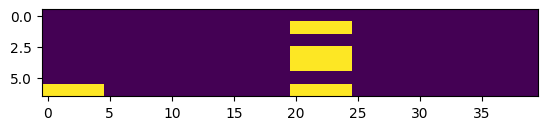

In [25]:
plt.imshow(u_val[0, 0:40, :].detach().cpu().numpy().T)

In [6]:
train_dataset = CustomDataset(u = u_train, x = x_train, device = rtrnn_trainer.model.device)
val_dataset = CustomDataset(u = u_val, x = x_val, device = rtrnn_trainer.model.device)
train_loader = DataLoader(train_dataset, batch_size=configs["training_config"]["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=configs["training_config"]["batch_size"], shuffle=False)

/home/timmy/projects/Tiny_RNN_RT/codes/Codes/CustomMapper/CustomMapper.py:345: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, device = device)
/home/timmy/projects/Tiny_RNN_RT/codes/Codes/CustomMapper/CustomMapper.py:346: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u = torch.tensor(u, device = device)


In [231]:
epochs = 200
rtrnn_trainer.train_loop(train_loader, val_loader, epochs = epochs)

Epoch 0 - Step 0 - train loss: 1.0741
Epoch 0 - Step 1 - train loss: 1.0541
Epoch 0 - Step 2 - train loss: 1.0347
Epoch 0 - Step 3 - train loss: 1.0164
Epoch 0 - Step 4 - train loss: 0.9964
Epoch 0 - Step 5 - train loss: 0.9679
Epoch 0 - Step 6 - train loss: 0.9383
Epoch 0 - Step 7 - train loss: 0.9074
Epoch 0 - Step 8 - train loss: 0.8678
Epoch 0 - Step 9 - train loss: 0.8741
Epoch 0 - Step 10 - train loss: 0.8565
Epoch 0 - Step 11 - train loss: 0.8336
Epoch 0 - Step 12 - train loss: 0.8080
Epoch 0 - val loss: 0.7924 | best: 0.7924
Epoch 1 - Step 0 - train loss: 0.7687
Epoch 1 - Step 1 - train loss: 0.7499
Epoch 1 - Step 2 - train loss: 0.7281
Epoch 1 - Step 3 - train loss: 0.6993
Epoch 1 - Step 4 - train loss: 0.6737
Epoch 1 - Step 5 - train loss: 0.6570
Epoch 1 - Step 6 - train loss: 0.6466
Epoch 1 - Step 7 - train loss: 0.6236
Epoch 1 - Step 8 - train loss: 0.6027
Epoch 1 - Step 9 - train loss: 0.6001
Epoch 1 - Step 10 - train loss: 0.6014
Epoch 1 - Step 11 - train loss: 0.5926
Epo

In [7]:
rtrnn_trainer.load_checkpoint(rtrnn_trainer.check_path / "best_model.pth")

In [15]:
rtrnn_trainer.model.eval()
u, x = val_dataset.u[:], val_dataset.x[:]
with torch.no_grad():
    out, h = rtrnn_trainer.model(u.float().to(rtrnn_trainer.model.device), return_h = True)

out = torch.softmax(out, dim = -1)


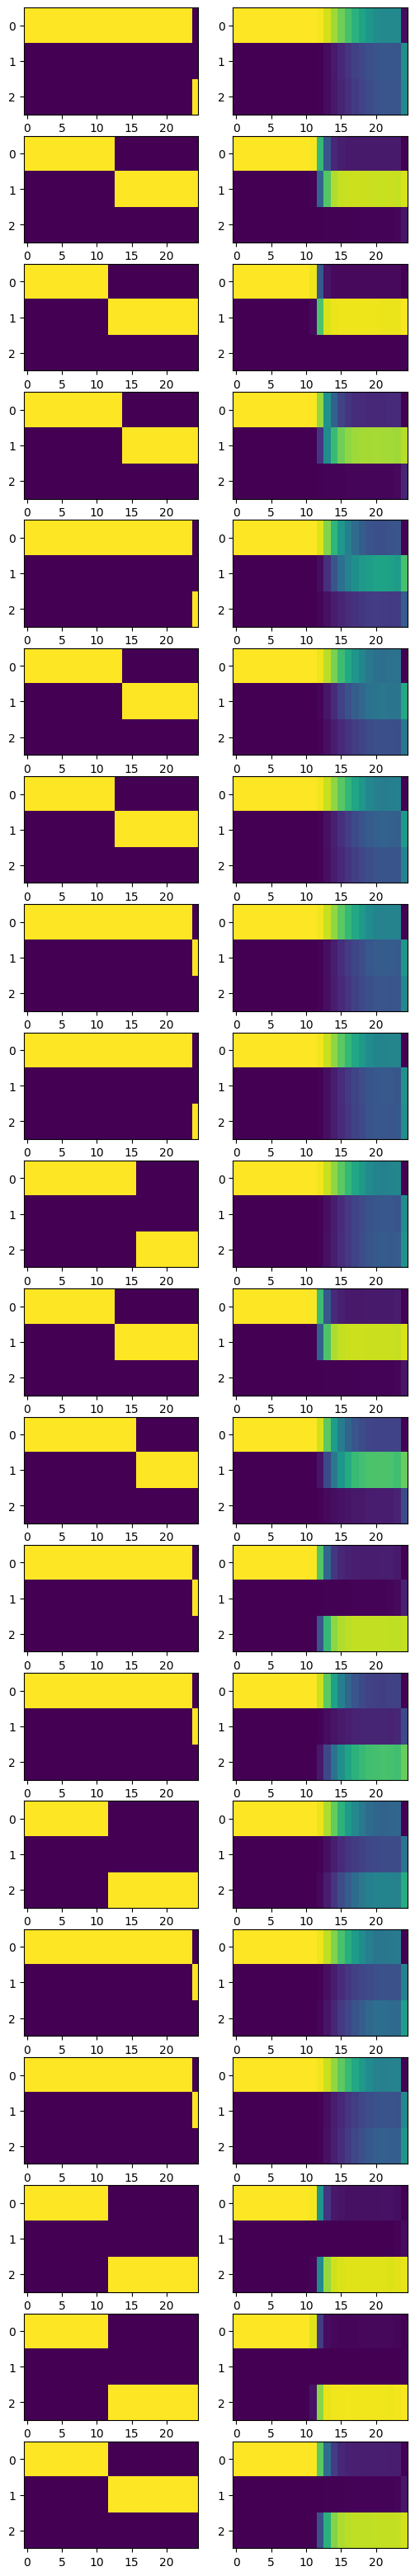

In [16]:
u_seg = u.reshape(u.shape[0], 100, -1, u.shape[-1])
x_seg_gt = x.reshape(x.shape[0], 100, -1, 3)
x_seg_pred = out.reshape(x.shape[0], 100, -1, 3)

fig, ax = plt.subplots(20, 2, figsize=(6, 40))
for i in range(20): 
    ax[i, 0].imshow(x_seg_gt[0, i, :, :].T.detach().cpu().numpy(), aspect='auto', cmap='viridis')
    ax[i, 1].imshow(x_seg_pred[0, i, :, :].T.detach().cpu().numpy(), aspect='auto', cmap='viridis')
# ax[0, 0].imshow(u_seg[0, 0, :, :].T.detach().cpu().numpy(), aspect='auto', cmap='viridis')
# ax[0, 1].imshow(u_seg[0, 0, :, :].T.detach().cpu().numpy(), aspect='auto', cmap='viridis')
# ax[1, 0].imshow(x_seg_gt[0, 1, :, :].T.detach().cpu().numpy(), aspect='auto', cmap='viridis')
# ax[1, 1].imshow(x_seg_pred[0, 50, :, :].T.detach().cpu().numpy(), aspect='auto', cmap='viridis')

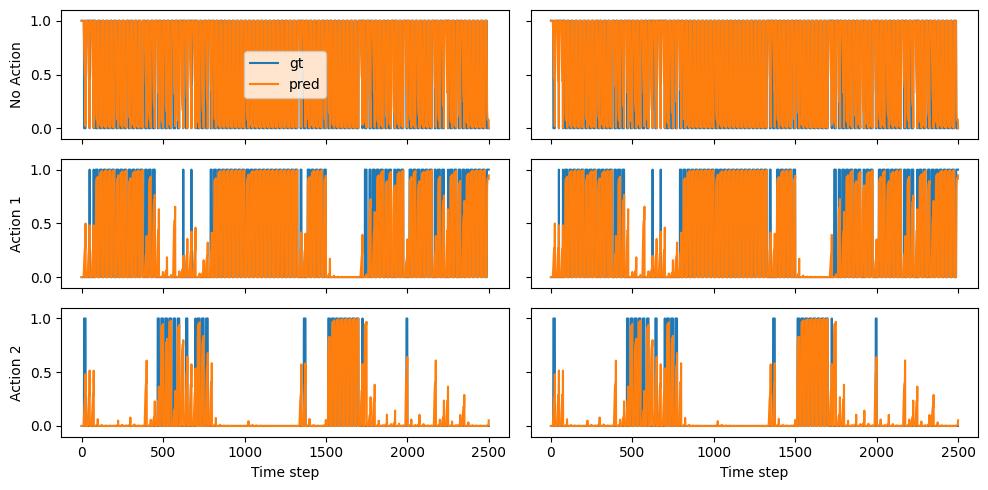

In [54]:
idx = 12
fig, ax = plt.subplots(3, 2, figsize=(10, 5), sharex='col', sharey='row')
plotted = x.shape[1]
ylabs = ['No Action', 'Action 1', "Action 2"]

# Plot for first plotted time steps
for i in range(3):
    ax[i, 0].plot(np.arange(plotted), x[idx, :plotted, i].detach().cpu().numpy(), label='gt')
    ax[i, 0].plot(np.arange(plotted), out[idx, :plotted, i].detach().cpu().numpy(), label='pred')
    ax[i, 0].set_ylim(-0.1, 1.1)
    ax[i, 0].set_ylabel(f'{ylabs[i]}')
    if i == 2:
        ax[i, 0].set_xlabel('Time step')

# Plot for last plotted time steps
for i in range(3):
    ax[i, 1].plot(np.arange(x.shape[1] - plotted, x.shape[1]), x[idx, -plotted:, i].detach().cpu().numpy(), label='gt')
    ax[i, 1].plot(np.arange(x.shape[1] - plotted, x.shape[1]), out[idx, -plotted:, i].detach().cpu().numpy(), label='pred')
    ax[i, 1].set_ylim(-0.1, 1.1)
    if i == 2:
        ax[i, 1].set_xlabel('Time step')

# Add legends only to the first subplot

ax[0, 0].legend()
fig.tight_layout()

plt.savefig(f'../../figures/discretised_rnn_output_example{"_pad_ones" if pad_ones else ""}_full.png')

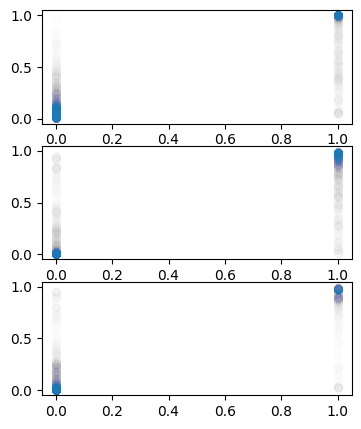

In [25]:
fig, ax = plt.subplots(3, 1, figsize=(4, 5))
ax[0].scatter(x[1, :, 0].detach().cpu().numpy().ravel(), out[1, :, 0].detach().cpu().numpy().ravel(), alpha = 0.002)
ax[1].scatter(x[1, :, 1].detach().cpu().numpy().ravel(), out[1, :, 1].detach().cpu().numpy().ravel(), alpha = 0.002)
ax[2].scatter(x[1, :, 2].detach().cpu().numpy().ravel(), out[1, :, 2].detach().cpu().numpy().ravel(), alpha = 0.002)

In [143]:
torch.bmm(x.float().reshape(-1, x.shape[-1]).unsqueeze(1), out.float().reshape(-1, out.shape[-1]).unsqueeze(2)) 

tensor([[[0.9989]],

        [[0.9997]],

        [[0.9999]],

        ...,

        [[2.1738]],

        [[2.0470]],

        [[1.4478]]], device='cuda:0')

In [144]:
x.sum(-1)

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 2.4948, 2.3595, 1.7530],
        [1.0000, 1.0000, 1.0000,  ..., 2.4948, 2.3595, 1.7530],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 2.4948, 2.3595, 1.7530],
        [1.0000, 1.0000, 1.0000,  ..., 2.4948, 2.3595, 1.7530],
        [1.0000, 1.0000, 1.0000,  ..., 2.4948, 2.3595, 1.7530]],
       device='cuda:0', dtype=torch.float64)

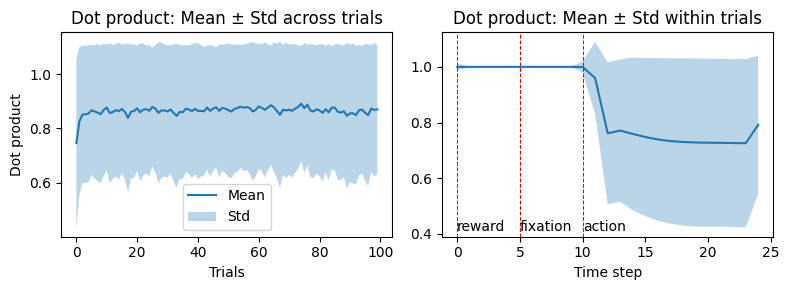

In [ ]:
dots = torch.bmm(x.float().reshape(-1, x.shape[-1]).unsqueeze(1), out.float().reshape(-1, x.shape[-1]).unsqueeze(2))
dots = dots.reshape(*x_seg_gt.shape[:-1])
mean_across_trial = dots.mean(dim = 0).mean(dim = -1)
std_across_trial = dots.permute(0, 2, 1).reshape(-1, dots.shape[1]).std(dim = 0)
mean_within_trial = dots.mean(dim = 0).mean(dim = 0)
std_within_trial = dots.reshape(-1, dots.shape[-1]).std(dim = 0)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# Plot mean and std across trials
ax[0].plot(mean_across_trial.cpu().numpy(), label='Mean')
ax[0].fill_between(np.arange(len(mean_across_trial)), 
                   (mean_across_trial - std_across_trial).cpu().numpy(), 
                   (mean_across_trial + std_across_trial).cpu().numpy(), 
                   alpha=0.3, label='Std')
ax[0].set_title('Dot product: Mean ± Std across trials')
ax[0].set_xlabel("Trials")
ax[0].set_ylabel('Dot product')
ax[0].legend()

# Plot mean and std within trials
ax[1].plot(mean_within_trial.cpu().numpy(), label='Mean')
ax[1].fill_between(np.arange(len(mean_within_trial)), 
                   (mean_within_trial - std_within_trial).cpu().numpy(), 
                   (mean_within_trial + std_within_trial).cpu().numpy(), 
                   alpha=0.3, label='Std')
task_events_lbls = ['reward', 'fixation', "action"]
task_events = [0, int(reward_presentation_time/dt), int((reward_presentation_time + fixation_time)/dt)]

for event, lbl in zip(task_events, task_events_lbls):
    ax[1].axvline(event, color='r', linestyle='--', lw=0.75)
    ax[1].text(event, 0.4, lbl, rotation=0, va='bottom', ha='left')

ax[1].set_title('Dot product: Mean ± Std within trials')
ax[1].set_xlabel('Time step')

fig.tight_layout()

fig.savefig(f'../../figures/discretised_rnn_dot_product{"_pad_ones" if pad_ones else ""}.png')


In [86]:
mean_across_trial.shape

torch.Size([100])

In [81]:
dots.shape

torch.Size([125000, 1, 1])

In [35]:
rtrnn_trainer.save_checkpoint(rtrnn_trainer.check_path / "best_model_no_fixation.pth", 0, 0)

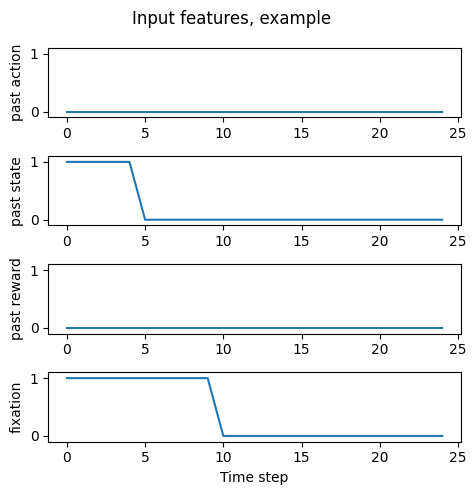

In [27]:
u_seg.shape
fig, ax = plt.subplots(4, 1, figsize=(5, 5))
idx = 5
ax[0].plot(u_seg[0, idx, :, 0].detach().cpu().numpy())
ax[1].plot(u_seg[0, idx, :, 2].detach().cpu().numpy())
ax[2].plot(u_seg[0, idx, :, 4].detach().cpu().numpy())
ax[3].plot(u_seg[0, idx, :, 6].detach().cpu().numpy())
for i, label in enumerate(['past action', 'past state', 'past reward', 'fixation']):
    ax[i].set_ylim(-.1, 1.1)
    ax[i].set_ylabel(label)
ax[-1].set_xlabel('Time step')
fig.suptitle('Input features, example')

fig.tight_layout()
plt.savefig("../../figures/input_features_example.png", dpi=300)

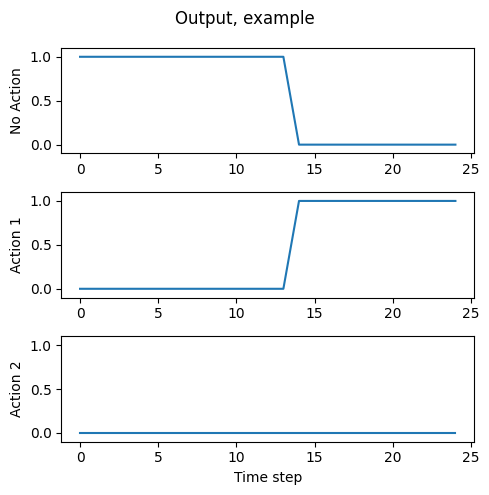

In [28]:
x_seg_gt.shape
fig, ax = plt.subplots(3, 1, figsize=(5, 5))
idx = 5
ax[0].plot(x_seg_gt[0, idx, :, 0].detach().cpu().numpy())
ax[1].plot(x_seg_gt[0, idx, :, 1].detach().cpu().numpy())
ax[2].plot(x_seg_gt[0, idx, :, 2].detach().cpu().numpy())
for i, label in enumerate(['No Action', 'Action 1', 'Action 2']):
    ax[i].set_ylim(-.1, 1.1)
    ax[i].set_ylabel(label)
ax[-1].set_xlabel('Time step')
fig.suptitle('Output, example')

fig.tight_layout()
plt.savefig(f"../../figures/output_example{'_pad_ones' if pad_ones else ''}.png", dpi=300)

In [29]:
h_segmented = h.reshape(h.shape[0], 100, -1, h.shape[-1])
h_segmented_actions = h_segmented[:, :, task_events[-1]:].reshape(-1, h.shape[-1])
h_segmented_all = h_segmented.reshape(-1, h.shape[-1])
x_seg_pred_actions = x_seg_pred[:, :, task_events[-1]:]


In [30]:
choice_pred = ((x_seg_pred_actions[..., 1].sum(-1) > x_seg_pred_actions[..., 2].sum(-1)).float() - 0.5 )* 2

In [31]:
param_dict = rtrnn_trainer.model.state_dict()

In [48]:
# perform PCA on the h_segmented_actions
u, s, v = torch.svd(h_segmented_all - h_segmented_all.mean(dim = 0, keepdim=True))
# u, s, v = torch.svd(h_segmented_actions - h_segmented_actions.mean(dim = 0, keepdim=True))
# h_pca = (h_segmented_all @ v[:, :]).reshape(h.shape[0], 100, 25, h.shape[-1]).detach().cpu().numpy()
h_pca = u.detach().cpu().numpy().reshape(h.shape[0], 100, -1, h.shape[-1])
# h_pca = (h_segmented_actions @ v[:, :]).reshape(h.shape[0], 100, 15, h.shape[-1]).detach().cpu().numpy()
# Select a batch to plot
batch_idx = 0
# Get the top 3 principal components for the selected batch
pcs = h_pca[batch_idx, :, :, :3]  # shape: (n_subtrials, timesteps, 3)

# Prepare data for plotly: flatten sub-trials and timesteps
n_subtrials, n_timesteps, _ = pcs.shape
pcs_flat = pcs.reshape(-1, 3)
time_flat = np.tile(np.arange(n_timesteps), n_subtrials)

# Assign a color for each sub-trial
subtrial_ids = np.repeat(np.arange(n_subtrials), n_timesteps)

fig = px.scatter_3d(
    x=pcs_flat[:, 0],
    y=pcs_flat[:, 1],
    z=pcs_flat[:, 2],
    color=time_flat * choice_pred[batch_idx].detach().cpu().repeat_interleave(n_timesteps).numpy(),  # color by time and choice
    # animation_frame=subtrial_ids,
    color_continuous_scale="RdBu", 
    title="Top 3 PCs Trajectories (colored by time, animated by sub-trial)",
    labels={'color': 'Time step'}
)
fig.update_traces(marker=dict(size=2))
fig.show()


In [269]:
# perform PCA on the h_segmented_actions
u, s, v = torch.svd(h_segmented_actions - h_segmented_actions.mean(dim = 0, keepdim=True))
h_pca = (h_segmented_actions @ v[:, :]).reshape(h.shape[0], 100, 15, h.shape[-1]).detach().cpu().numpy()
# Select a batch to plot
batch_idx = 1
# Get the top 3 principal components for the selected batch
pcs = h_pca[batch_idx, :, :, :3]  # shape: (n_subtrials, timesteps, 3)

# Prepare data for plotly: flatten sub-trials and timesteps
n_subtrials, n_timesteps, _ = pcs.shape
pcs_flat = pcs.reshape(-1, 3)
time_flat = np.tile(np.arange(n_timesteps), n_subtrials)

# Assign a color for each sub-trial
subtrial_ids = np.repeat(np.arange(n_subtrials), n_timesteps)

fig = px.scatter_3d(
    x=pcs_flat[:, 0],
    y=pcs_flat[:, 1],
    z=pcs_flat[:, 2],
    color=time_flat * choice_pred[batch_idx].detach().cpu().repeat_interleave(n_timesteps).numpy(),  # color by time and choice
    # animation_frame=subtrial_ids,
    color_continuous_scale="RdBu", 
    title="Top 3 PCs Trajectories (colored by time, animated by sub-trial)",
    labels={'color': 'Time step'}
)
fig.update_traces(marker=dict(size=2))
fig.show()


In [62]:
out

tensor([[[1.0000e+00, 1.6981e-06, 1.3208e-06],
         [1.0000e+00, 1.3396e-10, 1.4588e-10],
         [1.0000e+00, 3.0392e-12, 4.9966e-12],
         ...,
         [4.3940e-01, 2.6007e-01, 3.0053e-01],
         [4.4315e-01, 2.5559e-01, 3.0126e-01],
         [2.4087e-03, 4.6501e-01, 5.3258e-01]],

        [[1.0000e+00, 1.1006e-09, 1.2878e-10],
         [1.0000e+00, 1.9263e-13, 3.4635e-14],
         [1.0000e+00, 7.3457e-15, 2.5499e-15],
         ...,
         [1.3381e-01, 8.3853e-01, 2.7659e-02],
         [1.3286e-01, 8.2916e-01, 3.7980e-02],
         [2.7730e-03, 8.6632e-01, 1.3091e-01]],

        [[1.0000e+00, 1.7235e-08, 7.8898e-08],
         [1.0000e+00, 1.6349e-10, 9.1174e-10],
         [1.0000e+00, 1.3810e-11, 7.5425e-11],
         ...,
         [2.1803e-02, 9.7733e-01, 8.6779e-04],
         [2.1440e-02, 9.7715e-01, 1.4100e-03],
         [2.9694e-03, 9.9198e-01, 5.0465e-03]],

        ...,

        [[1.0000e+00, 1.1810e-06, 5.2219e-07],
         [1.0000e+00, 9.3525e-10, 3.6112e-10]

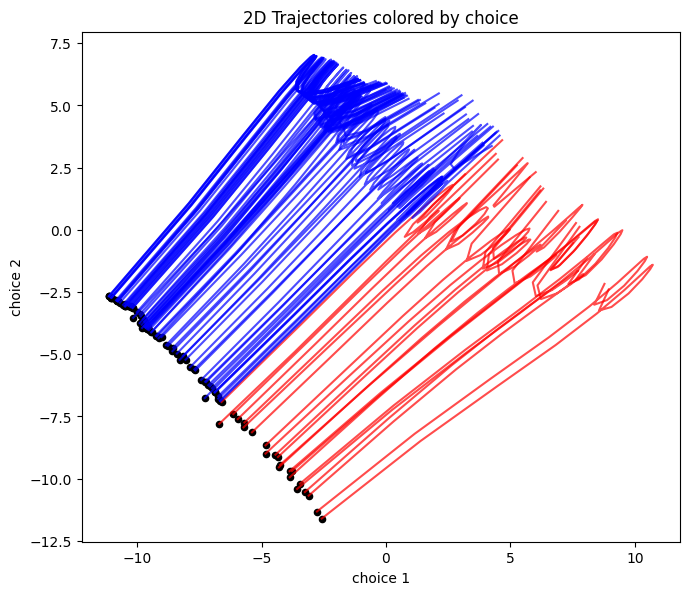

In [71]:
wt = param_dict['trial_output.0.weight'].T @ param_dict['trial_output.2.weight'].T
# perform PCA on the h_segmented_actions
h_pca = (h_segmented_actions @ wt[:, :]).reshape(h.shape[0], 100, 15, 3).detach().cpu().numpy()[..., 1:]
# h_pca = torch.log(out).reshape(h.shape[0], 100, 25, 3)[..., 10:, :].detach().cpu().numpy()[..., 1:]
# Select a batch to plot
batch_idx = 0
# Get the top 3 principal components for the selected batch
pcs = h_pca[batch_idx, :, :, :3]  # shape: (n_subtrials, timesteps, 3)

# Prepare data for plotly: flatten sub-trials and timesteps
if len(pcs.shape) == 3: 
    n_subtrials, n_timesteps, _ = pcs.shape
else: 
    n_timesteps, _ = pcs.shape
    n_subtrials = 1

pcs_flat = pcs.reshape(-1, 2)
time_flat = np.tile(np.arange(n_timesteps), n_subtrials)

# Assign a color for each sub-trial
subtrial_ids = np.repeat(np.arange(n_subtrials), n_timesteps)

# fig = px.scatter_3d(
#     x=pcs_flat[:, 0],
#     y=pcs_flat[:, 1],
#     z=pcs_flat[:, 2],
#     color=time_flat * choice_pred[batch_idx].detach().cpu().repeat_interleave(n_timesteps).numpy(),  # color by time and choice
#     # animation_frame=subtrial_ids,
#     color_continuous_scale="RdBu", 
#     title="Top 3 PCs Trajectories (colored by time, animated by sub-trial)",
#     labels={'color': 'Time step'}
# )
# Plot 2D trajectories, coloring each subtrajectory segment by its corresponding choice
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(7, 7))
colors = plt.cm.RdBu(np.linspace(0, 1, n_subtrials))

for i in range(n_subtrials):
    # Get the color for this subtrial based on choice_pred (should be -1 or 1)
    if hasattr(choice_pred, 'shape') and choice_pred.shape[0] > batch_idx:
        choice_val = choice_pred[batch_idx, i].detach().cpu().item() if choice_pred.ndim == 2 else choice_pred[batch_idx].detach().cpu().item()
    else:
        choice_val = 0
    color = 'red' if choice_val > 0 else 'blue'
    ax.plot(pcs[i, :, 0], pcs[i, :, 1], color=color, alpha=0.7)
    ax.scatter(pcs[i, 0, 0], pcs[i, 0, 1], color='black', marker='o', s=20)  # start point

ax.set_xlabel('choice 1')
ax.set_ylabel('choice 2')
ax.set_title('2D Trajectories colored by choice')
ax.set_aspect('equal')
plt.tight_layout()
# fig.update_traces(marker=dict(size=3))
# fig.update_layout(width=600, height=600)  # Make the figure square
# fig.show()
fig.savefig(f'../../figures/discretised_rnn_2d_trajectories{"_pad_ones" if pad_ones else ""}.png', dpi=300)


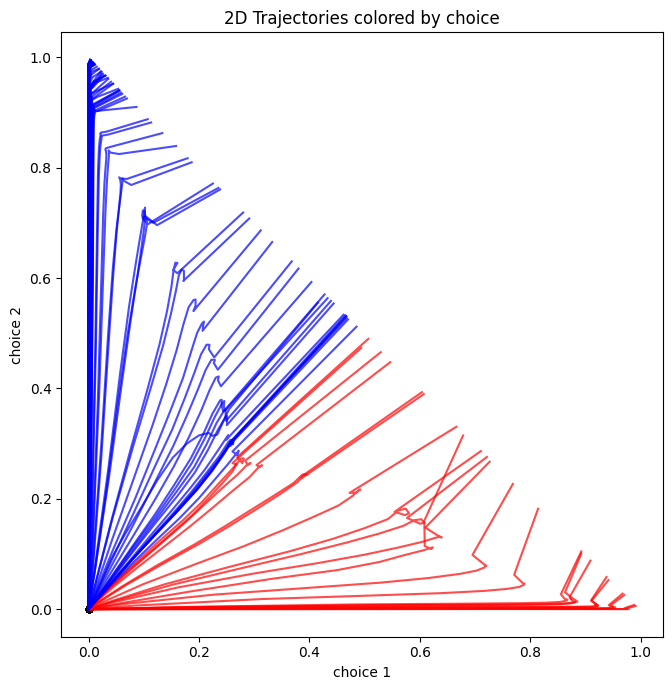

In [69]:
wt = param_dict['trial_output.0.weight'].T @ param_dict['trial_output.2.weight'].T
# perform PCA on the h_segmented_actions
# h_pca = torch.log(torch.softmax(h_segmented_actions @ wt[:, :], dim = -1).reshape(h.shape[0], 100, 15, 3).detach().cpu()).numpy()[..., 1:]
h_pca = (out).reshape(h.shape[0], 100, 25, 3)[..., 10:, :].detach().cpu().numpy()[..., 1:]
# Select a batch to plot
batch_idx = 0
# Get the top 3 principal components for the selected batch
pcs = h_pca[batch_idx, :, :, :3]  # shape: (n_subtrials, timesteps, 3)

# Prepare data for plotly: flatten sub-trials and timesteps
if len(pcs.shape) == 3: 
    n_subtrials, n_timesteps, _ = pcs.shape
else: 
    n_timesteps, _ = pcs.shape
    n_subtrials = 1

pcs_flat = pcs.reshape(-1, 2)
time_flat = np.tile(np.arange(n_timesteps), n_subtrials)

# Assign a color for each sub-trial
subtrial_ids = np.repeat(np.arange(n_subtrials), n_timesteps)

# fig = px.scatter_3d(
#     x=pcs_flat[:, 0],
#     y=pcs_flat[:, 1],
#     z=pcs_flat[:, 2],
#     color=time_flat * choice_pred[batch_idx].detach().cpu().repeat_interleave(n_timesteps).numpy(),  # color by time and choice
#     # animation_frame=subtrial_ids,
#     color_continuous_scale="RdBu", 
#     title="Top 3 PCs Trajectories (colored by time, animated by sub-trial)",
#     labels={'color': 'Time step'}
# )
# Plot 2D trajectories, coloring each subtrajectory segment by its corresponding choice
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(7, 7))
colors = plt.cm.RdBu(np.linspace(0, 1, n_subtrials))

for i in range(n_subtrials):
    # Get the color for this subtrial based on choice_pred (should be -1 or 1)
    if hasattr(choice_pred, 'shape') and choice_pred.shape[0] > batch_idx:
        choice_val = choice_pred[batch_idx, i].detach().cpu().item() if choice_pred.ndim == 2 else choice_pred[batch_idx].detach().cpu().item()
    else:
        choice_val = 0
    color = 'red' if choice_val > 0 else 'blue'
    ax.plot(pcs[i, :, 0], pcs[i, :, 1], color=color, alpha=0.7)
    ax.scatter(pcs[i, 0, 0], pcs[i, 0, 1], color='black', marker='o', s=20)  # start point

ax.set_xlabel('choice 1')
ax.set_ylabel('choice 2')
ax.set_title('2D Trajectories colored by choice')
ax.set_aspect('equal')
plt.tight_layout()
# fig.update_traces(marker=dict(size=3))
# fig.update_layout(width=600, height=600)  # Make the figure square
# fig.show()
fig.savefig(f'../../figures/discretised_rnn_2d_trajectories{"_pad_ones" if pad_ones else ""}.png', dpi=300)

In [66]:
out.shape

torch.Size([200, 2500, 3])

In [45]:
choice_pred[batch_idx, 1].detach().cpu()

tensor(1.)